## Time Series Forecasting
1. Naive method, Simple average method and the simple moving average method
2. Exponential Smoothing: Simple Exponential Smoothing technique, Holt’s method with trend and Holt Winter’s method
3. Auto Regressive methods: ARIMA/SARIMA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
from scipy.stats import variation

%matplotlib  inline
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

import sklearn
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv(r'C:\Users\a844050\Documents\Github\personal\data_science\forecasting\time_series\datasets\coffee_sales.csv')

In [3]:
print(f"{df.shape[0]} Rows & {df.shape[1]} Columns")
print("------")
print(df.dtypes)
df.head(5)

1395 Rows & 6 Columns
------
date            object
datetime        object
cash_type       object
card            object
money          float64
coffee_name     object
dtype: object


,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte


### Creating the time series data

In [5]:
df['date'] = pd.to_datetime(df['date'])
df_daily = df.groupby('date')['money'].sum().reset_index()
df_daily.head(5)

,date,money
0,2024-03-01,396.3
1,2024-03-02,228.1
2,2024-03-03,349.1
3,2024-03-04,135.2
4,2024-03-05,338.5


In [6]:
# Naive method: the forecast for the next value is the last observed value
df_daily['naive_forecast'] = df_daily['money'].shift(1)

# Simple average method: the forecast for all values is the mean of all past observations
df_daily['average_forecast'] = df_daily['money'].expanding().mean()

# Simple moving average method: the forecast for the next value is the mean of the last n observations
n = 5  # Choosing a window size of 5 days for moving average
df_daily['moving_average_forecast'] = df_daily['money'].rolling(window=n).mean()

# Display the dataframe with new forecast columns
df_daily.head(10)


,date,money,naive_forecast,average_forecast,moving_average_forecast
0,2024-03-01,396.3,NaN,396.300000,NaN
1,2024-03-02,228.1,396.3,312.200000,NaN
2,2024-03-03,349.1,228.1,324.500000,NaN
3,2024-03-04,135.2,349.1,277.175000,NaN
4,2024-03-05,338.5,135.2,289.440000,289.44
5,2024-03-06,170.2,338.5,269.566667,244.22
6,2024-03-07,220.1,170.2,262.500000,242.62
7,2024-03-08,265.5,220.1,262.875000,225.90
8,2024-03-09,479.4,265.5,286.933333,294.74
9,2024-03-10,231.6,479.4,281.400000,273.36


### Exponential Smoothing

In [7]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

# Simple Exponential Smoothing
ses_model = SimpleExpSmoothing(df_daily['money']).fit(smoothing_level=0.2, optimized=False)
df_daily['SES_forecast'] = ses_model.fittedvalues.shift(-1)

# Holt's method with trend
holt_model = ExponentialSmoothing(df_daily['money'], trend='add').fit()
df_daily['Holt_forecast'] = holt_model.fittedvalues

# Holt-Winters method with seasonality
# Assuming seasonality is weekly, we set the period to 7
holt_winters_model = ExponentialSmoothing(df_daily['money'], trend='add', seasonal='add', seasonal_periods=7).fit()
df_daily['Holt_Winters_forecast'] = holt_winters_model.fittedvalues

# Display the dataframe with new forecast columns
df_daily.head(10)


,date,money,naive_forecast,average_forecast,moving_average_forecast,SES_forecast,Holt_forecast,Holt_Winters_forecast
0,2024-03-01,396.3,NaN,396.300000,NaN,396.300000,283.053773,269.255239
1,2024-03-02,228.1,396.3,312.200000,NaN,362.660000,303.537433,334.154378
2,2024-03-03,349.1,228.1,324.500000,NaN,359.948000,289.036648,257.244491
3,2024-03-04,135.2,349.1,277.175000,NaN,314.998400,299.659640,294.326415
4,2024-03-05,338.5,135.2,289.440000,289.44,319.698720,268.651323,252.991340
5,2024-03-06,170.2,338.5,269.566667,244.22,289.798976,281.086298,253.560674
6,2024-03-07,220.1,170.2,262.500000,242.62,275.859181,260.009700,250.780416
7,2024-03-08,265.5,220.1,262.875000,225.90,273.787345,252.091476,244.702047
8,2024-03-09,479.4,265.5,286.933333,294.74,314.909876,254.058968,269.534298
9,2024-03-10,231.6,479.4,281.400000,273.36,298.247901,295.324895,280.740510


### Auto Regressive Methods

#### >> Stationary Test

In [8]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [9]:
def results_adfuller_test(pvalue, sig_level):
    if pvalue < sig_level: 
        return print(">> REJECT H_0: Time series is stationary, proceed without differencing")
    return print(">> Cannot reject H_0: Time series is not stationary, differencing is required")

result = adfuller(df['money'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 

print("\n")
results_adfuller_test(result[1],0.05)

ADF Statistic: -2.3778383721736076
p-value: 0.14808930098686046
Critial Values:
   1%, -3.4351321860409674
Critial Values:
   5%, -2.863651979448174
Critial Values:
   10%, -2.567894416324791


>> Cannot reject H_0: Time series is not stationary, differencing is required


#### >> Differencing

In [10]:
df_diff = df['money'].diff().dropna()
result = adfuller(df_diff, autolag='AIC')

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 

print("\n")
results_adfuller_test(result[1],0.05)

ADF Statistic: -13.42501454898775
p-value: 4.1183762284642846e-25
Critial Values:
   1%, -3.435135685820292
Critial Values:
   5%, -2.863653523836867
Critial Values:
   10%, -2.5678952387601703


>> REJECT H_0: Time series is stationary, proceed without differencing


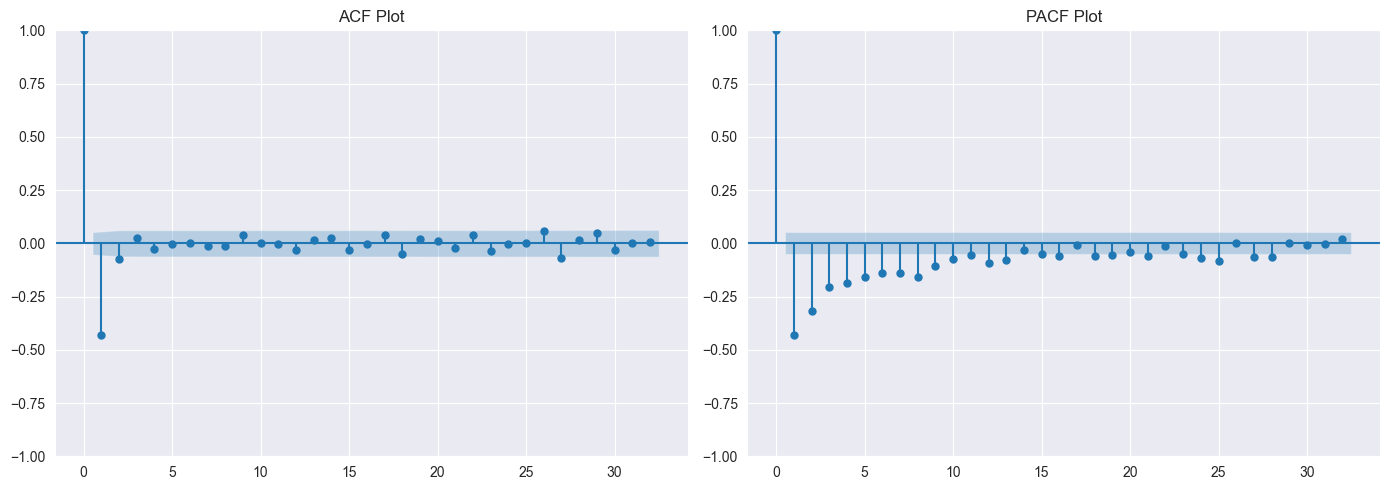

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(df_diff, ax=axes[0])
plot_pacf(df_diff, ax=axes[1])

axes[0].set_title('ACF Plot')
axes[1].set_title('PACF Plot')

plt.tight_layout()
plt.show()

#### Time Series Decomposition

In [11]:
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

In [12]:
temp = df.reset_index()[['datetime', 'money']].copy()
temp.index = np.array(temp['datetime'], dtype=np.datetime64)
temp = temp[['money']]
temp.head(3)

,money
2024-03-01 10:15:50.520,38.7
2024-03-01 12:19:22.539,38.7
2024-03-01 12:20:18.089,38.7


Daily Coffee Sales (Sum) Decomposition


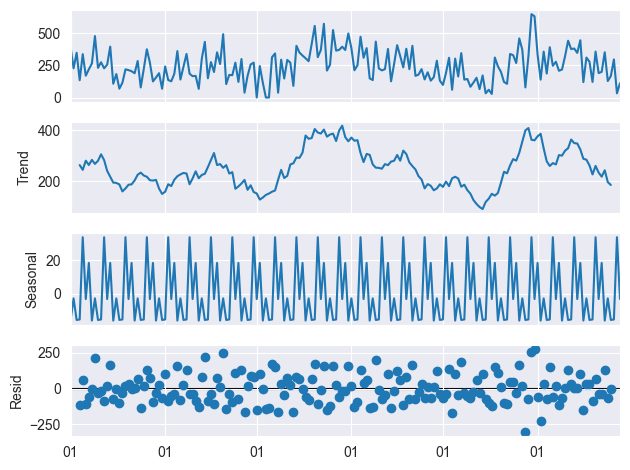

In [14]:
print('Daily Coffee Sales (Sum) Decomposition')
daily_data = temp.resample('D').sum()
result = seasonal_decompose(daily_data.dropna(), model='additive')
result.plot()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d'))
plt.show()

In [32]:
import pmdarima as pm

# Fit a SARIMA model automatically
model = pm.auto_arima(
    df_diff,
    seasonal=True, 
    m=7,  # e.g., if monthly data with yearly seasonality = 12, daily data with weekly seasonality = 7
    start_p=1, start_q=1, 
    max_p=3, max_q=3,
    d=None,  # Let the model determine if differencing is required
    D=1,  # Assume seasonal differencing is required
    trace=True,  # Prints progress
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True
)

# Summary of the model
print(model.summary())

# Forecasting
n_periods = 12  # e.g., forecast next 12 months
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

# Plot forecast
model.plot_predict(n_periods=n_periods)


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject